In [1]:
import pandas as pd
# df = pd.read_csv("/home/spatialuser/uribe/mapmetadata/jakarta_inf_metadata_ratio_cutoff_20250813-130617.csv")
df = pd.read_csv("/home/spatialuser/uribe/mapmetadata/jakarta_inf_metadata_20250813-105145.csv")
df.head()

,u,v,k,osmid,inf_oneway,osm_oneway,inf_exp_speed,inf_speed_limit,osm_maxspeed,inf_lanes,osm_lanes,osm_highway,count,min_s,max_s,q1,q2,q3,uv_vu
0,333629063,5481758371,0,1299936670,False,True,37.70,80,NaN,1,2.0,primary,397,4.54,75.45,37.07,37.70,38.25,"(224, 5)"
1,5481758371,5481758496,0,1299936670,False,True,38.66,40,NaN,1,2.0,primary,441,6.33,97.65,37.73,38.66,39.44,"(266, 5)"
2,5481758496,9015942211,0,1299936670,False,True,35.93,40,NaN,1,2.0,primary,602,0.68,117.83,34.01,35.93,37.36,"(421, 11)"
3,9015942211,2379752298,0,1299936670,False,True,35.53,50,NaN,1,2.0,primary,616,0.45,120.00,34.53,35.53,45.89,"(442, 6)"
4,2379752298,6396540207,0,1299936670,True,True,32.70,40,NaN,1,2.0,primary,182,0.45,113.00,23.21,32.70,38.94,"(46, 0)"


### Inferred Oneway

#### Accuracy

In [3]:
accuracy_with_na = (df['inf_oneway'] == df['osm_oneway']).mean()
df = df.dropna(subset='inf_oneway')
accuracy_wout_na = (df['inf_oneway'] == df['osm_oneway']).mean()
print(f"Accuracy:\n\twith NA vals: {accuracy_with_na}\n\tw/o NA vals: {accuracy_wout_na}")

Accuracy:
	with NA vals: 0.3314285714285714
	w/o NA vals: 0.3314285714285714


In [4]:
def resolve_oneway(group):
    if False in group.values:
        return False
    elif True in group.values:
        return True
    else:
        return False
# Group by 'osmid' and apply logic to 'oneway'
result = df.groupby('osmid')['inf_oneway'].apply(resolve_oneway).reset_index()
result

def resolve_oneway_osm(group):
    if False in group.values:
        return False
    elif True in group.values:
        return True
    else:
        return None

agg_result = df.groupby('osmid').agg({
    'inf_oneway': resolve_oneway,
    'osm_oneway': resolve_oneway_osm
}).reset_index()

agg_result

accuracy = (df['inf_oneway'] == df['osm_oneway']).mean()
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.3314


Matrix result for `/home/spatialuser/uribe/mapmetadata/jakarta_inf_metadata_20250813-105145.csv`

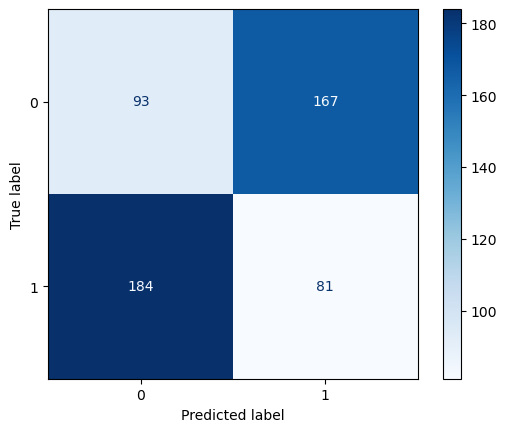

In [5]:
import sklearn.metrics as skl

cm = skl.confusion_matrix(list(df['osm_oneway']), list(df['inf_oneway']))
cm_display = skl.ConfusionMatrixDisplay(cm)
cm_display.plot(cmap='Blues')

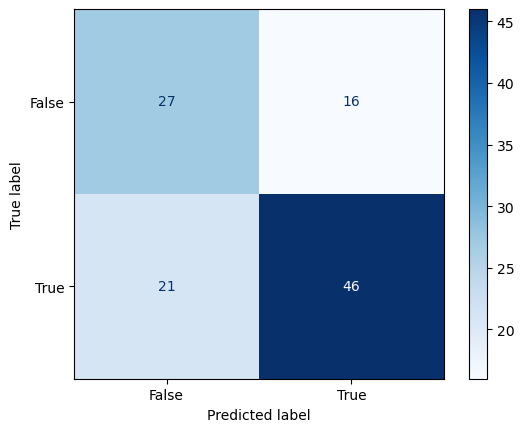

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
df_nona = df.dropna(subset=['inf_oneway'])
cm = confusion_matrix(list(df['osm_oneway']), list(df_nona['inf_oneway']))
labels = sorted(df['osm_oneway'].unique()) 
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
cm_display.plot(cmap='Blues')

#### False Positives/Negatives

In [47]:
# FUNC plot_counts
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import ast

def plot_counts(df, ax, title, xscale='linear', yscale='linear'):
    tuples = df['uv_vu'].apply(ast.literal_eval)
    uv = tuples.str[0]
    vu = tuples.str[1]

    ax.scatter(uv, vu, alpha = 0.7)

    ax.set_ylabel('v -> u')
    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
    ax.set_title(title)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
    # ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.grid(True)

    ax.axline((0,0), slope=1, color='red', linestyle='--', linewidth=1, label="x=y")
    ax.legend()

In [ ]:
# SUBSETTING df
false_negatives = df[~df['inf_oneway'] & df['osm_oneway']]
false_positives = df[df['inf_oneway'] & ~df['osm_oneway']]
true_negatives = df[~df['inf_oneway'] & ~df['osm_oneway']]
true_positives = df[df['inf_oneway'] & df['osm_oneway']]

In [55]:
# SUBSETTING false negatives
import numpy as np

false_negatives_cut = false_negatives[false_negatives['count'] < 2000]

tups = false_negatives_cut['uv_vu'].apply(ast.literal_eval)
fn_uv = tups.str[0]
fn_vu = tups.str[1]

ratio = []
for uv, vu in zip(fn_uv, fn_vu):
    min_val = min(uv, vu)
    max_val = max(uv, vu)
    ratio.append(min_val/max_val)

    # print(f"a: {min_val}\tb: {max_val}\ta/b: {round(min_val/max_val, 3)}")
false_negatives_cut['ratio'] = ratio
false_negatives_reasonable_ratio = false_negatives_cut[false_negatives_cut['ratio'] >= 0.5]
false_negatives_bad = false_negatives_cut[false_negatives_cut['ratio'] < 0.5]

/tmp/ipykernel_303844/1211835208.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_negatives_cut['ratio'] = ratio


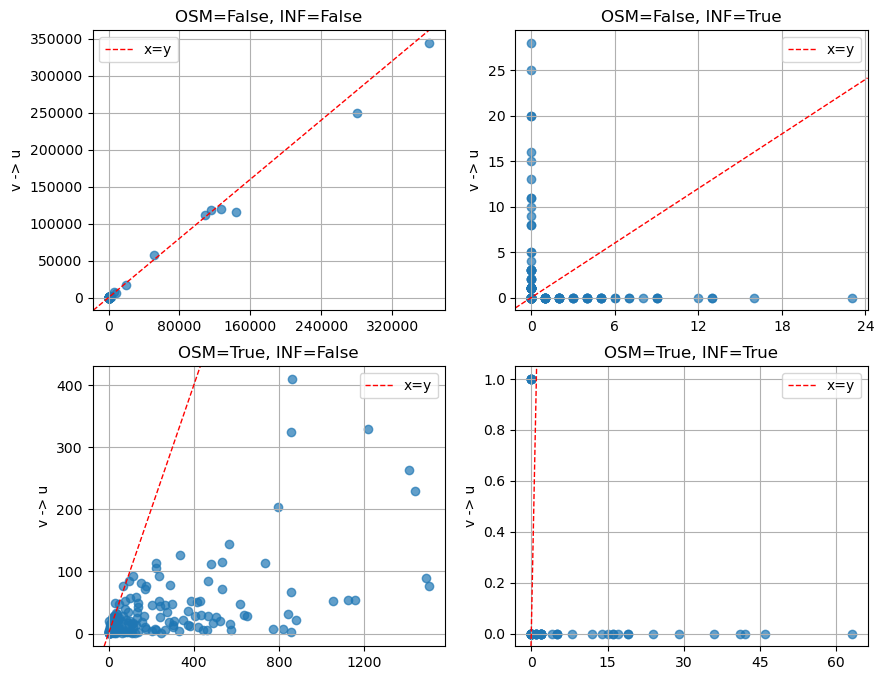

In [45]:
fig, axes = plt.subplots(2,2, figsize=(10,8))
plot_counts(true_negatives, axes[0,0], 'OSM=False, INF=False')
plot_counts(false_positives, axes[0,1], 'OSM=False, INF=True')
plot_counts(false_negatives_cut, axes[1,0],'OSM=True, INF=False')
plot_counts(true_positives, axes[1,1], 'OSM=True, INF=True')

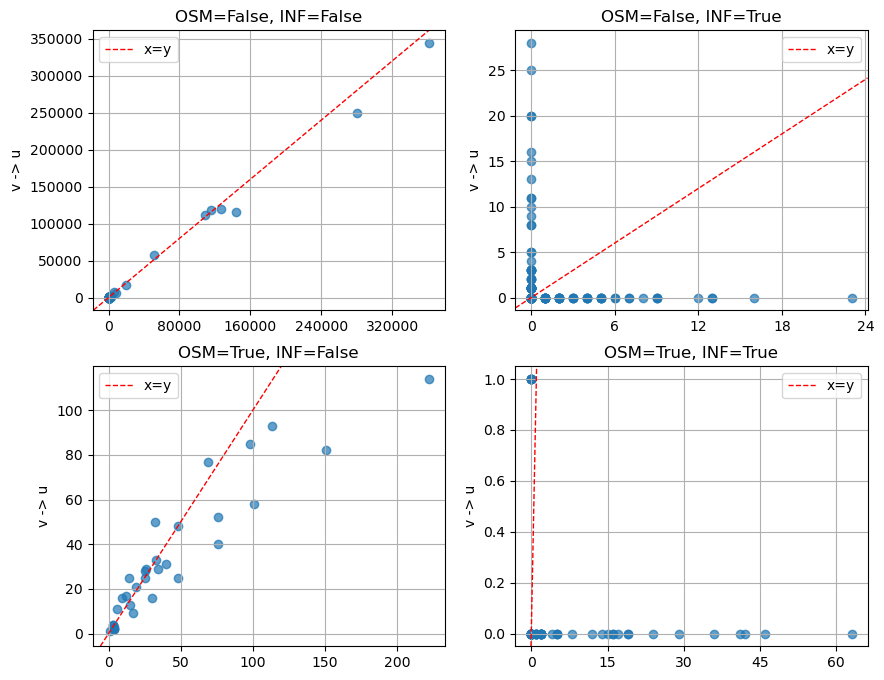

In [54]:
fig, axes = plt.subplots(2,2, figsize=(10,8))
plot_counts(true_negatives, axes[0,0], 'OSM=False, INF=False')
plot_counts(false_positives, axes[0,1], 'OSM=False, INF=True')
plot_counts(false_negatives_reasonable_ratio, axes[1,0],'OSM=True, INF=False')
plot_counts(true_positives, axes[1,1], 'OSM=True, INF=True')

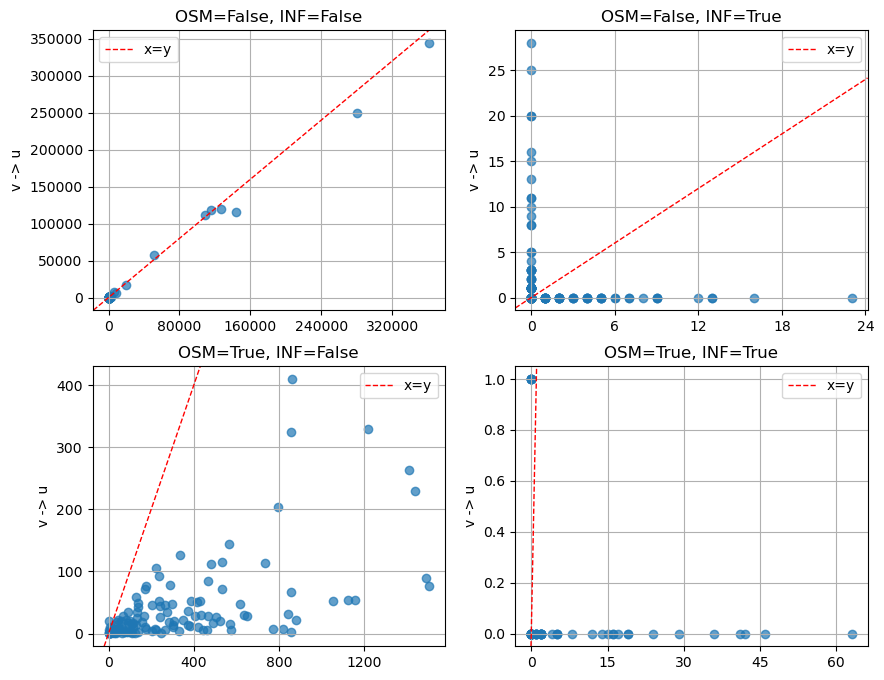

In [56]:
fig, axes = plt.subplots(2,2, figsize=(10,8))
plot_counts(true_negatives, axes[0,0], 'OSM=False, INF=False')
plot_counts(false_positives, axes[0,1], 'OSM=False, INF=True')
plot_counts(false_negatives_bad, axes[1,0],'OSM=True, INF=False')
plot_counts(true_positives, axes[1,1], 'OSM=True, INF=True')

### Inferred Speed Limit

In [2]:
inf_speed_counts = df['inf_speed_limit'].value_counts()
osm_speed_counts = df['osm_maxspeed'].value_counts()
print(f"inferred speed limits: {inf_speed_counts}\nosm speed limits: {osm_speed_counts}")

inferred speed limits: inf_speed_limit
40     121
50     100
30      75
60      73
20      54
70      46
80      27
10      21
90       4
100      2
130      1
110      1
Name: count, dtype: int64
osm speed limits: Series([], Name: count, dtype: int64)


In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

data = np.concatenate(())

### Number of Lanes

In [ ]:
fig, axes = plt.subplot(2,2, figsize=(6,4))

# axes[0,0].